### Robot Learning

### Assignment 8

Solutions are due on 17.06.2025 before the lecture.

## Task 8.1)

Consider a pendulum with point-mass $m = 2.5 kg$ and length $l = 6.7 m$.

The state $s$ is described by angle $\theta$ (deviation from upright) and angular speed $\dot{\theta} = \omega$.

Gravity and friction act on the pendulum. The dampening force due to friction is proportional to the angular velocity and described by the factor $\gamma = 1$. 

Control actions $a_t$ produce a torque around the pendulum hinge joint.

Model the system behavior as a discrete-time system with a step size of $\vartriangle = 0.01 s$!

Compute the evolution of the state over $10 s$ for an initial state of $\theta_0 = 0.5 rad$
and $\omega_0 = - 0.8\frac{rad}{s}$ with zero control input.

You can simulate the system behaviour by applying Euler's method and iterating

$s_{t + \vartriangle} \approx s_t + \vartriangle \cdot \dot{s_t} + \begin{pmatrix} 0 \\ \frac{1}{I} \end{pmatrix} \cdot a_t$

with $s_t = \begin{pmatrix} \theta_t \\ \omega_t \end{pmatrix}$, $\dot{s_t} = \begin{pmatrix} \omega_t \\ \ddot{\theta_t} \end{pmatrix}$ and the moment of interia $I = m \cdot l^2$.

During simulation, enforce $\theta_t \in [-\pi,\pi]$. Finally, show the system evolution by plotting $\theta$ and $\omega$ against time.

<div style="text-align: right; font-weight:bold"> 5 Points </div>

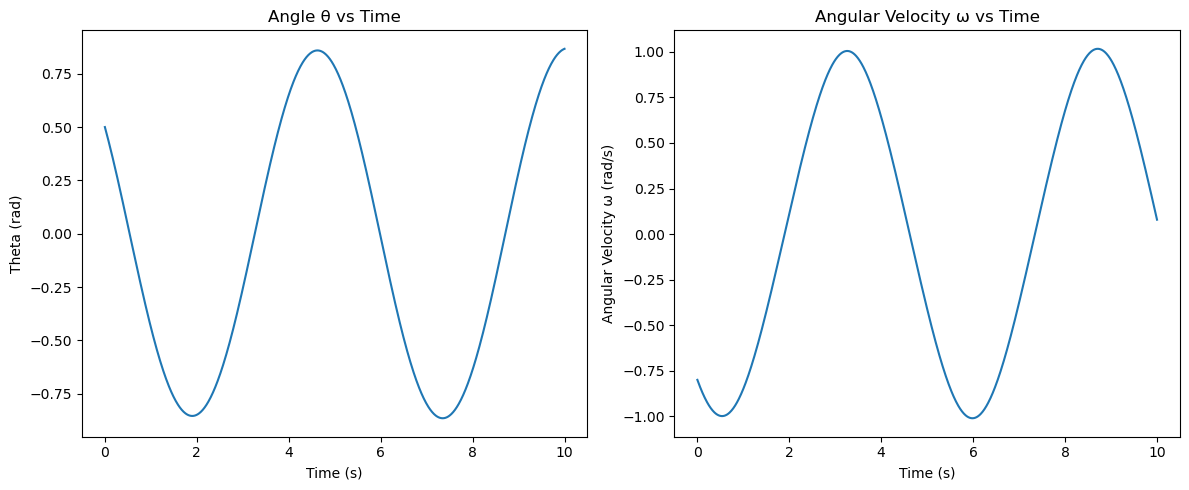

In [1]:
# Your code can go here

import numpy as np
import matplotlib.pyplot as plt

m = 2.5  
l = 6.7  
g = 9.81 
gamma = 1  
I = m * l**2  
dt = 0.01 
T = 10  
n_steps = int(T / dt)

theta = 0.5 
omega = -0.8  

theta_array = np.zeros(n_steps)
omega_array = np.zeros(n_steps)
time_array = np.linspace(0, T, n_steps)

for t in range(n_steps):
    theta_array[t] = theta
    omega_array[t] = omega
    alpha = - (g / l) * np.sin(theta) - (gamma / I) * omega
    theta += dt * omega
    omega += dt * alpha
    theta = (theta + np.pi) % (2 * np.pi) - np.pi

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(time_array, theta_array)
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Angle θ vs Time')

plt.subplot(1, 2, 2)
plt.plot(time_array, omega_array)
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity ω (rad/s)')
plt.title('Angular Velocity ω vs Time')

plt.tight_layout()
plt.show()

## Task 8.2)

Linearize the system around the upward state with zero angular velocity: ($\theta = 0$, $\omega = 0$).

Provide a linear state transition model

$s_{t+\vartriangle} = A \cdot s_t + B \cdot a_t$

for the pendulum system dynamics and compare the evolution of the state for this linearized system with the original dynamics for the same initial state of $\theta_0 = 0.5 rad$ and $\omega_0 = -0.8 \frac{rad}{s}$ with zero control input. Again enforce $\theta_t \in [-\pi,\pi]$ during simulation. 

<div style="text-align: right; font-weight:bold"> 4 Points </div>

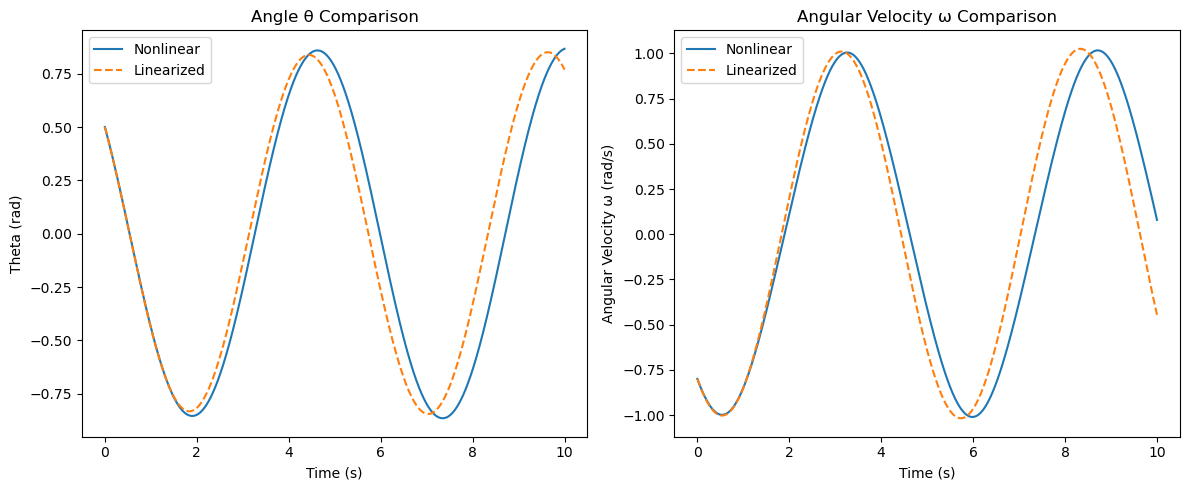

In [2]:
# Your code can go here

A_c = np.array([
    [0, 1],
    [-g/l, -gamma/I]
])
B_c = np.array([
    [0],
    [1/I]
])

A = np.eye(2) + dt * A_c
B = dt * B_c

s = np.array([0.5, -0.8])  
s_linear_array = np.zeros((n_steps, 2))

for t in range(n_steps):
    s_linear_array[t] = s
    s = A @ s  
    
    s[0] = (s[0] + np.pi) % (2 * np.pi) - np.pi

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_array, theta_array, label='Nonlinear')
plt.plot(time_array, s_linear_array[:, 0], label='Linearized', linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Angle θ Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_array, omega_array, label='Nonlinear')
plt.plot(time_array, s_linear_array[:, 1], label='Linearized', linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity ω (rad/s)')
plt.title('Angular Velocity ω Comparison')
plt.legend()

plt.tight_layout()
plt.show()


## Task 8.3)

Define a reward function which penalizes deviation from the standing still upright state and the magnitude of control actions in a quadratic way.

<div style="text-align: right; font-weight:bold"> 2 Points </div>

In [3]:
# Your reward function can go here

def reward_function(theta, omega, action):
    state_cost = q_theta * theta**2 + q_omega * omega**2
    action_cost = r_action * action**2
    return - (state_cost + action_cost)

## Task 8.4)

Use the method of Linear Quadratic Regulation (LQR) to design a state-feedback policy which optimizes your cost function from **Task 8.3)** over a time horizon of $0.7 s$, starting from the initial condition $\theta_0 = 0.5 rad$ and $\omega_0 = -0.8 \frac{rad}{s}$.

Show how the state evolves when the policy is applied for the original system dynamics without linearization.

<div style="text-align: right; font-weight:bold"> 7 Points </div>

Note that

$(B^T \cdot \Phi_{t+1} \cdot B - R)^{-1} \cdot B^T \cdot \Phi_{t+1} =: Z$

is used both in the calculation of $\Phi_t$ and $L_t$. It is also noteworthy that $\Psi$ is not used for control at all.

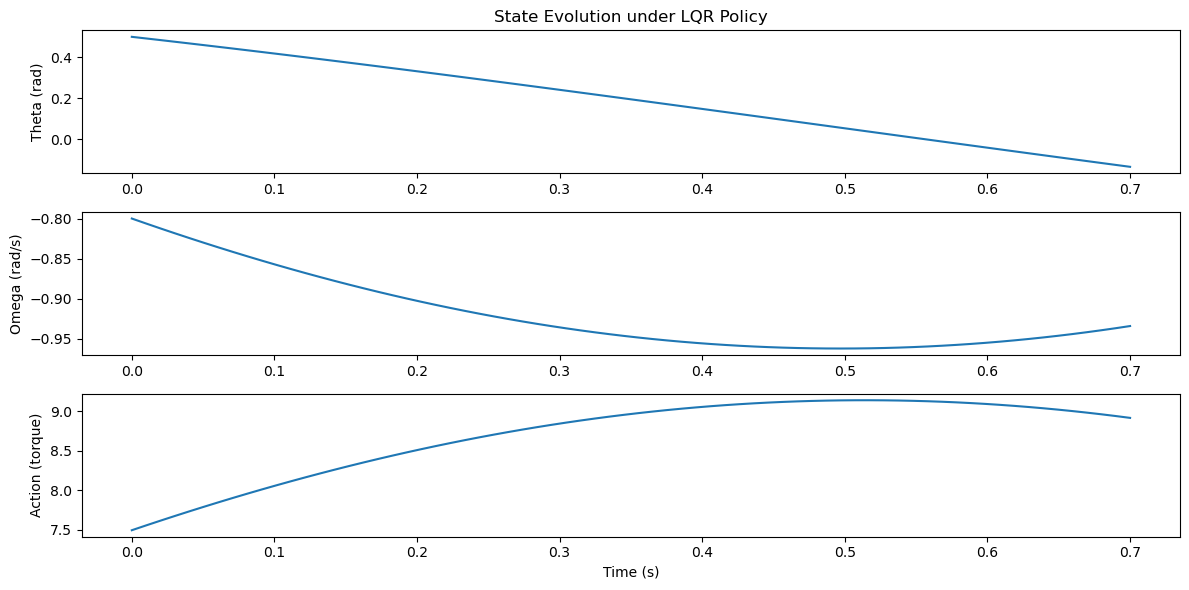

In [4]:
# Your code can go here

from scipy.linalg import solve_discrete_are
T = 0.7
n_steps = int(T / dt)

A = np.eye(2) + dt * A_c
B = dt * B_c

Q = np.diag([10.0, 1.0])
R = np.array([[0.1]])
P = solve_discrete_are(A, B, Q, R)
K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)

theta = 0.5
omega = -0.8
s = np.array([theta, omega])
states = np.zeros((n_steps, 2))
actions = np.zeros(n_steps)

for t in range(n_steps):
    states[t] = s
    a = (-K @ s).item()
    actions[t] = a
    alpha = - (g / l) * np.sin(s[0]) - (gamma / I) * s[1] + (1 / I) * a
    s[0] += dt * s[1]
    s[1] += dt * float(alpha)
    s[0] = (s[0] + np.pi) % (2 * np.pi) - np.pi

time_array = np.linspace(0, T, n_steps)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time_array, states[:, 0])
plt.ylabel('Theta (rad)')
plt.title('State Evolution under LQR Policy')

plt.subplot(3, 1, 2)
plt.plot(time_array, states[:, 1])
plt.ylabel('Omega (rad/s)')

plt.subplot(3, 1, 3)
plt.plot(time_array, actions)
plt.ylabel('Action (torque)')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

## Task 8.5)

Add zero-mean Gaussian noise with covariance matrix $\Sigma= diag(3\mathrm{e}{-6}, 4\mathrm{e}{-6})$ to the state after each transition and compare how the state evolves when above policy is applied from the same initial conditions, again simulating the original system dynamics without linearization.

<div style="text-align: right; font-weight:bold"> 2 Points </div>

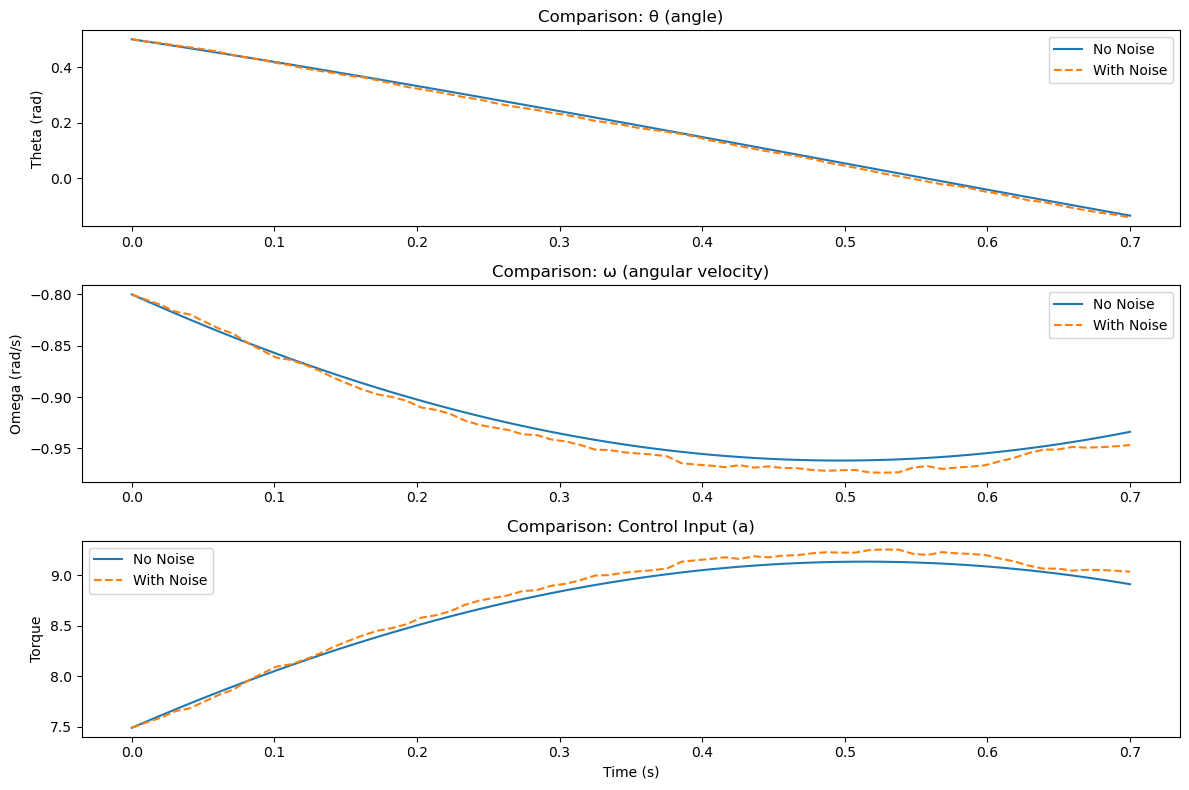

In [16]:
# Your code can go here

np.random.seed(42)
noise_cov = np.diag([3e-6, 4e-6])

theta = 0.5
omega = -0.8
s = np.array([theta, omega])
states_noisy = np.zeros((n_steps, 2))
actions_noisy = np.zeros(n_steps)


for t in range(n_steps):
    states_noisy[t] = s
    a = (-K @ s).item()
    actions_noisy[t] = a
    alpha = - (g / l) * np.sin(s[0]) - (gamma / I) * s[1] + (1 / I) * a
    s[0] += dt * s[1]
    s[1] += dt * alpha.item()
    noise = np.random.multivariate_normal(mean=[0, 0], cov=noise_cov)
    s += noise
    s[0] = (s[0] + np.pi) % (2 * np.pi) - np.pi

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time_array, states[:, 0], label='No Noise')
plt.plot(time_array, states_noisy[:, 0], label='With Noise', linestyle='dashed')
plt.ylabel('Theta (rad)')
plt.title('Comparison: θ (angle)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_array, states[:, 1], label='No Noise')
plt.plot(time_array, states_noisy[:, 1], label='With Noise', linestyle='dashed')
plt.ylabel('Omega (rad/s)')
plt.title('Comparison: ω (angular velocity)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_array, actions, label='No Noise')
plt.plot(time_array, actions_noisy, label='With Noise', linestyle='dashed')
plt.ylabel('Torque')
plt.xlabel('Time (s)')
plt.title('Comparison: Control Input (a)')
plt.legend()

plt.tight_layout()
plt.show()